# Explore the Hierarchical class

This notebook explores the base functionality of Hierarchical as this base functionality is introduced.

For now, Hierarchical is indeed instantiated as a subclass of Sequential, but only inherits the methods that specify how the layer architecture works. If more general architectures are added, the actual implementation will be moved up. Currently, this implementation already involves the general Model API in keras.

## Methods in Sequential

In [1]:
import keras
seq = keras.Sequential()

Using TensorFlow backend.
W0830 16:04:13.270175 139747659605824 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [8]:
seq.add(keras.layers.Dense(10, input_shape=(4, )))

W0828 14:54:07.034281 140407269582656 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 14:54:07.037168 140407269582656 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


Essentially, the thing we must add is a possibility to infer arbitrary states; essentially a state layer. Later, this will be ample opportunity to specify different kinds of state layers (think probabilistic, a la Srinivasan, etc.). Later, we may thus have more than two different modes of estimation, but for now, we have state and weight parameter estimation. This means that effectively, we have multiple sequential models -- which also means that we might as well just explicitly have an entirely new class.

The overall UI should enable state-to-state thinking. Conceptually, there are two levels of a predictive coding model: on one level, there are the state inference layers. On the other hand, each of these inferred states is being used to predict the state blow, the lowest state being actually observed. The supernetworks should be specified in a bottom-up fashion, whereas the subnetworks should be specified in a top-down fashion. When Hierarchical is initialized, it should thus be initialized in a top-down fashion.

The following syntax thus seems sensible:

Or, as a more complex example:

Pro: Hierarchical models can be built in a bottom up fashion.
Con: There's a somewhat unnecessary doubling of state estimation and state -- or at least the input shape there.
However, I can see certain advantages with that kind of verbosity, as well.

As a first step, I will implement the pure interface plus printing.


Revamp: There are essentially three different modi: adding the state tiers, adding the tier models, and adding the connections between the tiers.

In [35]:
seq = keras.Sequential()
seq.add(keras.layers.Dense(10, input_shape=(4, )))
seq.add(keras.layers.Activation('relu'))
seq.add(keras.layers.Dense(4))
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                50        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 44        
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


Importantly, we separate the user interface from the implementation via the appropriate class methods. Though I have not looked at that yet, this should make an alternative backend to Tensorflow easier.

This kind of interface has now been achieved:

In [2]:
import predicode as pc
import keras
hpc = pc.Hierarchical()
hpc.add_tier(shape=(10, ))
hpc.add_tier(shape=(4, ))
hpc.predictor = keras.Sequential()
hpc.predictor.add(keras.layers.Dense(4, input_shape=(10, )))
hpc.summary()

W0830 16:04:18.893996 139747659605824 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 16:04:18.905709 139747659605824 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



# Tier 1: tier_1
## Connecting Predictor
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 44        
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________
## Connection State Prediction
(No state prediction defined.)
# Tier 0: tier_0


Now, we tackle the real meat of Hierarchical: the estimation.

## Example estimation

Our estimation consists of an interplay between state variables and their corresponding minimizers, and models and their corresponding minimizers.

### Example data

In [354]:
art = pc.decaying_multi_normal(dimensions=10, size=100)

In [355]:
import tensorflow as tf

### State variables

In [356]:
tier_0 = tf.constant(art, name = 'tier_0', dtype=tf.float32)

In [357]:
tier_1_initial = pc.init('random', columns=4, rows=100)

In [358]:
tier_1 = tf.Variable(tier_1_initial, name = 'hierarchical_1_tier_1', dtype=tf.float32)

### Predictors

In [359]:
predictor_1 = keras.Sequential([keras.layers.Dense(10, input_shape=(4, ), use_bias=False)])

In [360]:
predictor_1

In [361]:
predicted_1 = predictor_1(tier_1)

### State prediction

In [362]:
loss = keras.losses.mean_squared_error(tier_0, predicted_1)

In [363]:
init_op = tf.global_variables_initializer()

In [364]:
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(loss))

[0.25360444 0.22708221 0.0162115  0.02750648 0.11611382 0.05579837
 0.01782483 0.01400409 0.18456575 0.2195266  0.03926224 0.11332171
 0.16874531 0.18739022 0.48242077 0.18214998 0.3583482  0.13900527
 0.761213   0.29731005 0.01002112 0.10913886 0.07890564 0.08191447
 0.01689442 0.00465213 0.02475609 0.3952284  0.17162569 0.0084704
 0.00558436 0.03944265 0.05324567 0.05877722 0.00574681 0.04137947
 0.42664728 0.0127202  0.16638245 0.05489131 0.01352558 0.15624201
 0.1070043  0.11062206 0.02763974 0.02389851 0.0126999  0.4434076
 0.08436457 0.14109716 0.13791429 0.24067771 0.01010384 0.01050533
 0.04059715 0.03878767 0.13854215 0.24737802 0.05857478 0.26247895
 0.02099425 0.09011039 0.04268298 0.22133084 0.00573754 0.03962309
 0.21524036 0.05308912 0.04217167 0.28271243 0.20865652 0.09021195
 0.02156907 0.03422244 0.31455955 0.06558277 0.20684285 0.16278024
 0.25961897 0.91579616 0.15638778 0.02675242 0.23569699 0.02741941
 0.0320649  0.17602226 0.19689794 0.19700928 0.1530825  0.110802

### State estimation

In [365]:
state_optimizer = tf.train.GradientDescentOptimizer(learning_rate=1)

In [366]:
loss

<tf.Tensor 'Mean_15:0' shape=(100,) dtype=float32>

In [367]:
state_step = state_optimizer.minimize(loss, var_list=(tier_1))

In [368]:
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(tier_1)[0, ])
    sess.run(state_step)
    print(sess.run(tier_1)[0, ])

[ 0.03243238  0.2186738  -0.02018487  0.02575708]
[-0.13920164 -0.02962834  0.09834187  0.00599605]


In [369]:
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(tier_1)[0, ])
    for i in range(10):
        sess.run(state_step)
    print(sess.run(tier_1)[0, ])

[ 0.03243238  0.2186738  -0.02018487  0.02575708]
[-0.4991267  -0.5025747   0.26580867 -0.2504718 ]


### Predictor estimation

In [370]:
predictor_optimizer = tf.train.GradientDescentOptimizer(learning_rate=1)

In [371]:
predictor_loss = tf.math.reduce_mean(loss)

In [372]:
predictor_loss

<tf.Tensor 'Mean_16:0' shape=() dtype=float32>

In [373]:
predictor_step = predictor_optimizer.minimize(predictor_loss, var_list = predictor_1.weights)

In [374]:
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(predictor_loss))
    for i in range(1000):
        sess.run(predictor_step)
    print(predictor_1.get_weights())
    for i in range(100):
        sess.run(state_step)
    print(sess.run(tier_1)[0, ])
    print(predictor_1.get_weights())
    for i in range(100):
        sess.run(predictor_step)
    for i in range(100):
        sess.run(state_step)
    print(sess.run(tier_1)[0, ])
    print(predictor_1.get_weights())
    print(sess.run(predictor_loss))

0.14465778
[array([[-1.7108925e-02, -2.5487083e-01,  3.9950970e-01, -7.4577510e-01,
        -5.3083360e-02, -1.3094580e-01,  4.9180683e-01, -2.6958224e-01,
        -3.0999517e-02, -3.9294282e-01],
       [-3.4616698e-02, -1.8440261e-02, -1.9149692e-01, -1.5493933e-03,
         1.6140562e-01,  8.5759163e-02,  1.4126500e-01,  8.5966391e-03,
         1.0085887e-01, -1.2573749e-01],
       [-1.4346266e-01, -2.2139332e-01,  1.3662139e+00, -1.8113140e+00,
        -5.9843414e-02, -6.2998980e-01,  5.7082003e-01, -7.4901414e-01,
        -7.6817781e-02, -5.1907384e-01],
       [-2.5155081e-03,  1.9905902e-01, -2.5483847e-01,  3.8675079e-01,
        -4.3461457e-02,  1.7035905e-01, -1.9656603e-01,  9.7926654e-02,
        -9.1270842e-02,  2.2500600e-01]], dtype=float32)]
[0.3333633  0.2093298  0.4824954  0.34900895]
[array([[-1.7108925e-02, -2.5487083e-01,  3.9950970e-01, -7.4577510e-01,
        -5.3083360e-02, -1.3094580e-01,  4.9180683e-01, -2.6958224e-01,
        -3.0999517e-02, -3.9294282e-01],

This ought to have given us some intuition for how this process should work, so we will now single out the different steps. Clearly, the tiers should simply be Tensorflow variables.

In [375]:
predictor_1.compile(tf.train.GradientDescentOptimizer(learning_rate=10), loss='mean_squared_error')

In [376]:
init_op = tf.global_variables_initializer()

In [477]:
with tf.Session() as sess:
    init_op.run()
    for i in range(100):
        for i in range(1000):
            state_step.run()
        predictor_1.fit(tier_1, tier_0, steps_per_epoch=50, epochs=1)
    final_weights = predictor_1.get_weights()

Epoch 1/1
50/50 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 1/1
 1/50 [..............................] - ETA: 0s - loss: 4.0384e-04

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7f194df4ad40>
Traceback (most recent call last):
  File "/home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


50/50 [==============================] - 0s 871us/step - loss: 3.3246e-04
Epoch 1/1
50/50 [==============================] - 0s 869us/step - loss: 2.7726e-04
Epoch 1/1
50/50 [==============================] - 0s 1ms/step - loss: 2.6677e-04
Epoch 1/1
50/50 [==============================] - 0s 1ms/step - loss: 2.6462e-04
Epoch 1/1
50/50 [==============================] - 0s 1ms/step - loss: 2.6399e-04
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6360e-04
Epoch 1/1
50/50 [==============================] - 0s 887us/step - loss: 2.6320e-04
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 2.6273e-04
Epoch 1/1
50/50 [==============================] - 0s 994us/step - loss: 2.6216e-04
Epoch 1/1
50/50 [==============================] - 0s 838us/step - loss: 2.6146e-04
Epoch 1/1
50/50 [==============================] - 0s 764us/step - loss: 2.6062e-04
Epoch 1/1
50/50 [==============================] - 0s 932us/step - loss: 2.5960e-04
Epoch 1/1
50

In [478]:
import sklearn.decomposition as decomp

In [493]:
pca = decomp.PCA(10).fit(art)

In [495]:
pca_weights = pca.components_[:4]
pca.explained_variance_

array([1.21951185e+00, 1.47887111e-01, 1.78051538e-02, 2.19805505e-03,
       2.92805709e-04, 4.94937281e-05, 6.15893716e-06, 6.60351392e-07,
       1.10990880e-07, 1.06866469e-08])

In [496]:
final_weights[0].shape

(4, 10)

In [497]:
import scipy
angles = scipy.linalg.subspace_angles(final_weights[0].T, pca_weights.T)
angles

array([5.24617272e-03, 1.50873588e-05, 1.14442212e-06, 2.81435079e-07])

In [498]:
import numpy as np
np.rad2deg(angles)

array([3.00583555e-01, 8.64441984e-04, 6.55705576e-05, 1.61250422e-05])

The algorithm indeed seems to find the PCA subspace. I am not sure why the accuracy is so low, though. (I had increased the iterations and nothing changed.)

In [507]:
normalized_weights = final_weights[0] / np.linalg.norm(final_weights[0], 2, axis=1, keepdims=True)

In [512]:
contribs = np.matmul(np.linalg.inv(pca.components_).T, normalized_weights.T)

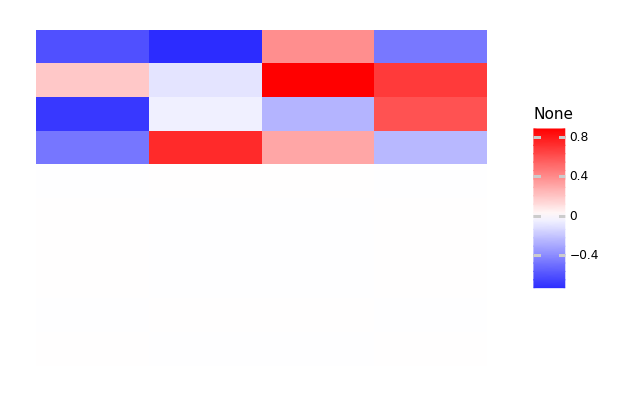

<ggplot: (8734010135609)>

In [514]:
import lazytools_sflippl as lazytools
lazytools.matrix_heatmap(contribs, pole=0)

This speaks a pretty clear language though.

In [516]:
np.linalg.norm(contribs, 2, axis=1)

array([1.07781646e+00, 1.08374561e+00, 9.05683455e-01, 9.18434088e-01,
       4.56237665e-03, 1.25316886e-04, 1.45934388e-03, 3.39127943e-04,
       2.85356887e-05, 3.78326325e-04])

Same precision, however. This implies reasonable confidence that all errors are numerical, and we can look at an optimization of that after the first implementation.